In [41]:
import numpy as np
from sklearn.linear_model import LinearRegression
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('default')
sns.set_palette("colorblind")
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.weight'] = 'light'
rcParams['mathtext.fontset'] = 'cm'
rcParams['mathtext.rm'] = 'serif'
mpl.rcParams["figure.dpi"] = 500
import cartopy.crs as ccrs
import cartopy as ct
import matplotlib.colors as c
import regionmask
import cmasher as cmr
import scipy
from cartopy.util import add_cyclic_point
mpl.rcParams['hatch.linewidth'] = 0.375
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from geocat.comp import eofunc_eofs, eofunc_pcs
from datetime import datetime
import warnings
from matplotlib.patches import Rectangle
import pdo_functions
import importlib
importlib.reload(pdo_functions)
import random
import numba
import statsmodels.api as sm
import pandas as pd
from scipy.stats import pearsonr

In [2]:
# Open SST data
sst = xr.open_dataset('/hurrell-scratch2/ivyglade/pdo/HadISST_sst.nc')['sst']

In [3]:
# Fill SST
sst_fill = xr.where(sst < -1.8, -1.8, sst)

In [4]:
# Open convective weather environment data
cape  = xr.open_mfdataset('/hurrell-scratch2/ivyglade/pdo/wrf_cape/era5_daily_max_mucape_*s.nc', combine='nested', concat_dim='year')['__xarray_dataarray_variable__']
s06   = xr.open_mfdataset('/hurrell-scratch2/ivyglade/pdo/ERA5_S06/era5_s06_*s.nc', combine='nested', concat_dim='time')['__xarray_dataarray_variable__']
ndsev = xr.open_mfdataset('/hurrell-scratch2/ivyglade/pdo/ndsev/diff_trapp_ndsev_mam_1940-2024.nc')['__xarray_dataarray_variable__']

In [5]:
# Subset conus
s06_conus = s06.sel(latitude=slice(49, 24)).sel(longitude=slice(235, 294))

In [6]:
# Change the shape of CAPE data
cape_stack = cape.stack(time=('year', 'date'))

# Convert time to datetime
year = cape_stack['time'].get_index('time').get_level_values('year')
date = cape_stack['time'].get_index('time').get_level_values('date')

datetime = pd.to_datetime(year.astype(str) + '-' + date.astype(str))

cape_stack = cape_stack.assign_coords(time=datetime)

/scratch/ivyglade/miniconda3/envs/myenv_py39/lib/python3.9/site-packages/xarray/core/dataset.py:5195: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explicitly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  stacked_var = exp_var.stack(**{new_dim: dims})
/tmp/ipykernel_231078/1241373606.py:10: FutureWarning: updating coordinate 'time' with a PandasMultiIndex would leave the multi-index level coordinates ['year', 'date'] in an inconsistent state. This will raise an error in the future. Use `.drop_vars(['time', 'year', 'date'])` before assigning new coordinate values.
  cape_stack = 

In [7]:
# Select 1940-2024
cape_1940_2024 = cape_stack.sel(time=cape_stack.time.dt.year.isin(np.arange(1940, 2025, 1)))
s06_1940_2024  = s06_conus.sel(time=s06_conus.time.dt.year.isin(np.arange(1940, 2025, 1)))

# Select March, April and May
cape_1940_2024_mam = cape_1940_2024.sel(time=cape_1940_2024.time.dt.month.isin([3, 4, 5])).dropna(dim='time')
s06_1940_2024_mam = s06_1940_2024.sel(time=s06_1940_2024.time.dt.month.isin([3, 4, 5])).dropna(dim='time')
ndsev_1940_2024_mam = ndsev

In [8]:
# Take MAM mean for CAPE and S06 
cape_1940_2024_mam_mean = cape_1940_2024_mam.resample(time='YE').mean().load()
s06_1940_2024_mam_mean = s06_1940_2024_mam.resample(time='YE').mean().load()

In [9]:
# Compute NDSEV during MAM
ndsev_monthly = np.zeros((85, 101, 237))
for i in range(85):
    ndsev_monthly[i] = ndsev_1940_2024_mam.isel(time=slice(i*92, (i+1)*92)).transpose('time', 'latitude', 'longitude').values.sum(axis=0)

In [10]:
# Convert ndsev to xr
ndsev_1940_2024_mam_count = xr.DataArray(ndsev_monthly.swapaxes(0, 2).swapaxes(0, 1), coords={'latitude':ndsev['latitude'], 'longitude':ndsev['longitude'], 'time':cape_1940_2024_mam_mean['time']}, \
                                         dims=['latitude', 'longitude', 'time'])

In [34]:
# Subset the eastern US
cape_east = cape_1940_2024_mam_mean.sel(longitude=slice(pdo_functions.convert_longitudes(-101), pdo_functions.convert_longitudes(-83))).sel(latitude=slice(47, 31))
s06_east = s06_1940_2024_mam_mean.sel(longitude=slice(pdo_functions.convert_longitudes(-101), pdo_functions.convert_longitudes(-83))).sel(latitude=slice(47, 31))
ndsev_east = ndsev_1940_2024_mam_count.sel(longitude=slice(pdo_functions.convert_longitudes(-101), pdo_functions.convert_longitudes(-83))).sel(latitude=slice(47, 31))

In [26]:
# Area weight and take spatial mean
weights = np.cos(np.deg2rad(cape_east.latitude))

cape_east_mean = cape_east.weighted(weights).mean(dim=('latitude', 'longitude'))
s06_east_mean = s06_east.weighted(weights).mean(dim=('latitude', 'longitude'))
ndsev_east_mean = ndsev_east.weighted(weights).mean(dim=('latitude', 'longitude'))

In [27]:
# Detrend
cape_east_mean_de = pdo_functions.detrend_dim(cape_east_mean, 'time', 2)
s06_east_mean_de = pdo_functions.detrend_dim(s06_east_mean, 'time', 2)
ndsev_east_mean_de = pdo_functions.detrend_dim(ndsev_east_mean, 'time', 2)

In [28]:
# Subset 1940-2024 SST
sst_1940_2024 = sst_fill.sel(time=sst_fill.time.dt.year.isin(np.arange(1940, 2025, 1)))
sst_1940_2024_mam = sst_1940_2024.sel(time=sst_1940_2024.time.dt.month.isin([3, 4, 5]))

# Take the seasonal mean
sst_1940_2024_mam_mean = sst_1940_2024_mam.resample(time='YE').mean()

In [29]:
# Detrend SSTs
sst_de = pdo_functions.detrend_dim(sst_1940_2024_mam_mean, 'time', 2)

In [30]:
# standardize everything
cape_east_mean_de_std = (cape_east_mean_de - cape_east_mean_de.mean(dim='time')) / cape_east_mean_de.std(dim='time')
s06_east_mean_de_std = (s06_east_mean_de - s06_east_mean_de.mean(dim='time')) / s06_east_mean_de.std(dim='time')
ndsev_east_mean_de_std = (ndsev_east_mean_de - ndsev_east_mean_de.mean(dim='time')) / ndsev_east_mean_de.std(dim='time')

sst_de_std = (sst_de - sst_de.mean(dim='time')) / sst_de.std(dim='time')

In [36]:
# lets apply a 5 year rolling mean here to isolate low frequency variability
cape_east_mean_de_rolling = cape_east_mean_de_std.rolling(time=5, center=True).mean()
s06_east_mean_de_rolling = s06_east_mean_de_std.rolling(time=5, center=True).mean()
ndsev_east_mean_de_rolling = ndsev_east_mean_de_std.rolling(time=5, center=True).mean()

In [37]:
# Correlate SSTs with convective weather environments
cape_corr = xr.corr(sst_de_std, cape_east_mean_de_std, dim='time')
s06_corr = xr.corr(sst_de_std, s06_east_mean_de_std, dim='time')
ndsev_corr = xr.corr(sst_de_std, ndsev_east_mean_de_std, dim='time')

cape_rolling_corr = xr.corr(sst_de_std, cape_east_mean_de_rolling, dim='time')
s06_rolling_corr = xr.corr(sst_de_std, s06_east_mean_de_rolling, dim='time')
ndsev_rolling_corr = xr.corr(sst_de_std, ndsev_east_mean_de_rolling, dim='time')

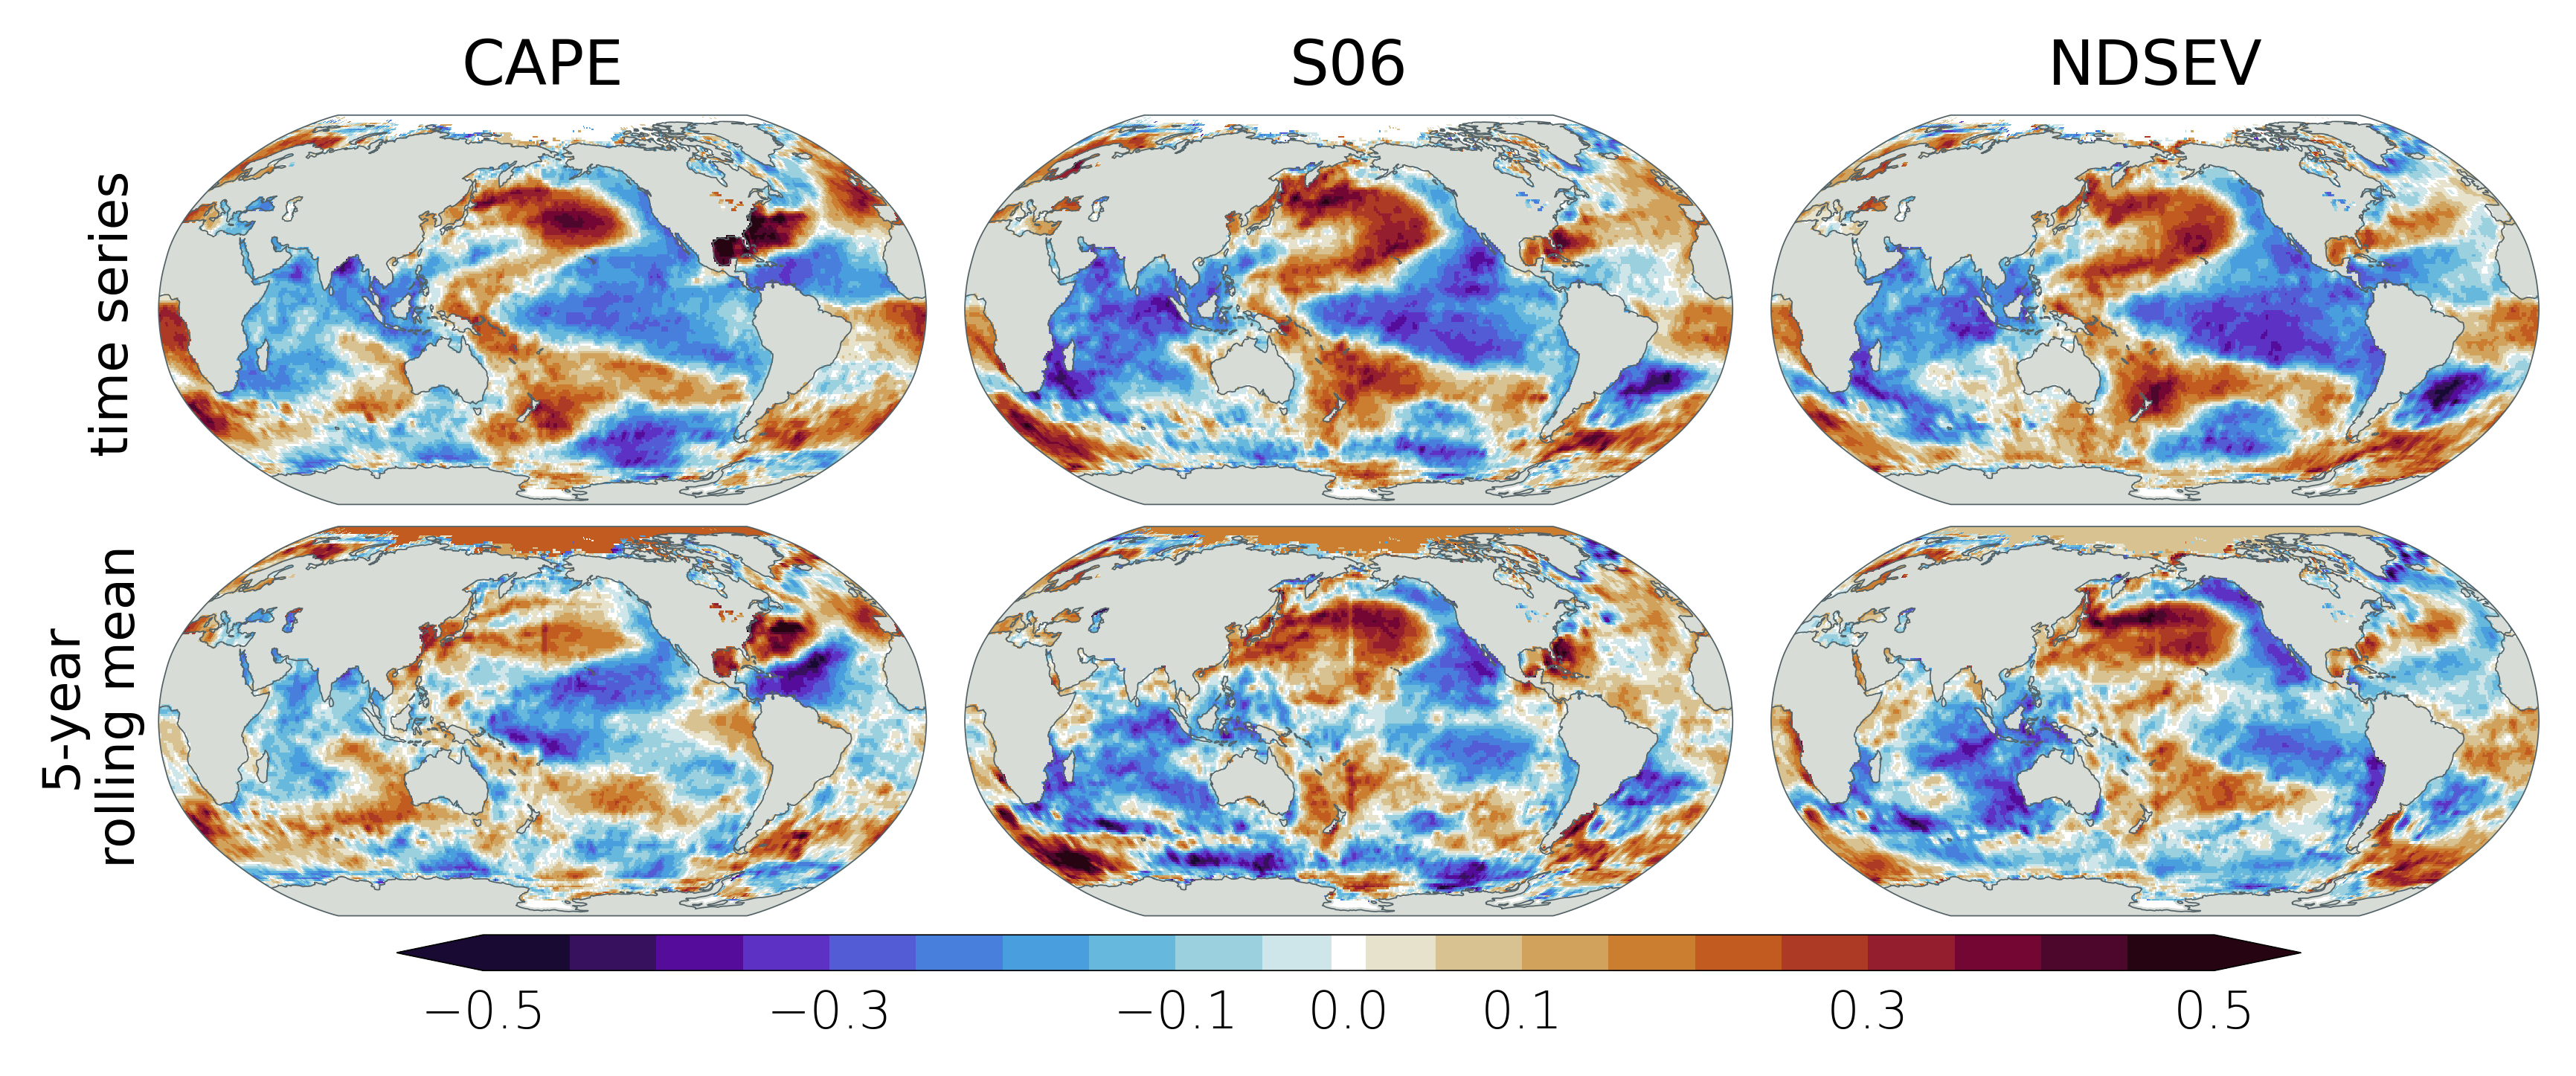

In [54]:
fig, ax = plt.subplots(2, 3, subplot_kw=dict(projection=ccrs.Robinson(central_longitude=180)))

bounds = [-0.5, -0.45, -0.4, -0.35, -0.3, -0.25, -0.2, -0.15, -0.1, -0.05, -0.01, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
norm = c.BoundaryNorm(bounds, plt.get_cmap('cmr.fusion_r').N)

ax = [ax[0, 0], ax[0, 1], ax[0, 2], \
      ax[1, 0], ax[1, 1], ax[1, 2]]

for i in range(6):
    ax[i].coastlines(lw=0.25, color='xkcd:gunmetal')
    ax[i].spines['geo'].set_edgecolor('xkcd:gunmetal')
    ax[i].spines['geo'].set_linewidth(0.25)
    ax[i].add_feature(ct.feature.LAND, color='xkcd:light gray')

ax[0].pcolormesh(cape_corr['longitude'], cape_corr['latitude'], cape_corr, transform=ccrs.PlateCarree(), norm=norm, cmap='cmr.fusion_r')
ax[1].pcolormesh(s06_corr['longitude'], s06_corr['latitude'], s06_corr, transform=ccrs.PlateCarree(), norm=norm, cmap='cmr.fusion_r')
ax[2].pcolormesh(ndsev_corr['longitude'], ndsev_corr['latitude'], ndsev_corr, transform=ccrs.PlateCarree(), norm=norm, cmap='cmr.fusion_r')

ax[3].pcolormesh(cape_corr['longitude'], cape_corr['latitude'], cape_rolling_corr, transform=ccrs.PlateCarree(), norm=norm, cmap='cmr.fusion_r')
ax[4].pcolormesh(s06_corr['longitude'], s06_corr['latitude'], s06_rolling_corr, transform=ccrs.PlateCarree(), norm=norm, cmap='cmr.fusion_r')
ax[5].pcolormesh(ndsev_corr['longitude'], ndsev_corr['latitude'], ndsev_rolling_corr, transform=ccrs.PlateCarree(), norm=norm, cmap='cmr.fusion_r')

cax = plt.axes([0.1, .22, 0.8, 0.02])
cbar = plt.colorbar(mpl.cm.ScalarMappable(cmap='cmr.fusion_r', norm=norm), cax=cax, orientation='horizontal', spacing='proportional', extend='both', \
                    ticks=[-0.5, -0.3, -0.1, 0, 0.1, 0.3, 0.5])
cbar.set_label(r'', size=10, fontweight='normal', color='black')
cbar.ax.tick_params(which='both', labelsize=10, width=0.5, length=0, labelcolor='black')
cbar.outline.set_linewidth(0.25)
cbar.outline.set_color('black')
# cbar.outline.set_visible(False)

ax[0].set_title('CAPE')
ax[1].set_title('S06')
ax[2].set_title('NDSEV')

ax[0].text(-19000000, -6000000, 'time series', fontweight='normal', rotation='vertical', ha='center')
ax[3].text(-20000000, -6000000, '5-year\nrolling mean', fontweight='normal', rotation='vertical', ha='center')

plt.subplots_adjust(left=0,
                    bottom=0.25, 
                    right=1., 
                    top=0.7, 
                    wspace=0.05, 
                    hspace=0.05)